
# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [3]:
pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 15.1 MB/s eta 0:00:00


In [4]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [5]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [6]:
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0
        self.size = 0
        self.cap = capacity

    def add(self, s, a, r, sp, term):
        i = self.ptr % self.cap
        self.obs[i] = s
        self.act[i] = a
        self.nxt[i] = sp
        self.rew[i, 0] = r
        self.term[i, 0] = term
        self.ptr += 1
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        idx = np.random.randint(0, self.size, size=batch)
        s  = self.obs[idx]
        a  = self.act[idx]
        sp = self.nxt[idx]
        ds = sp - s     # Δs = s' - s
        return s, a, ds

# Create the replay buffer instance
replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [7]:
def collect_random(env, replay, steps=100000, seed=42):
    set_seed(seed)
    s, _ = env.reset(seed=seed)
    for _ in range(steps):
        a = env.action_space.sample()
        sp, r, term, trunc, _ = env.step(a)
        replay.add(s, a, r, sp, float(term or trunc))
        s = sp
        if term or trunc:
            s, _ = env.reset()
    return replay.size


n = collect_random(env, replay, steps=100000, seed=42)
print("Collected steps:", n)


Collected steps: 100000



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [8]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# ------------------------------------------------------------
# Function: update_normalizers_from_buffer(replay)
# ------------------------------------------------------------
def update_normalizers_from_buffer(replay):
    # Collect data from buffer
    n = replay.size
    obs = replay.obs[:n]
    act = replay.act[:n]
    nxt = replay.nxt[:n]
    ds  = nxt - obs  # Δs = s' - s


    obs_norm.update(obs)
    inp_norm.update(np.concatenate([obs, act], axis=-1))
    targ_norm.update(ds)


update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [9]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim  = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)

# Optimizer & LR scheduler (Exponential decay per epoch)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

# (Optional but useful) device move + quick shape sanity check
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)

@th.no_grad()
def _sanity_forward():
    if replay.size == 0:
        print("Replay is empty; run Task 2 first.")
        return
    s, a, ds = replay.sample(batch=32)
    x = np.concatenate([s, a], axis=-1)
    x_n = inp_norm.normalize(x)           # normalized [s,a]
    x_t = to_t(x_n).to(device)
    yhat = model(x_t)                     # normalized Δs
    print("Input shape:", x_t.shape, "| Pred shape (Δs_norm):", yhat.shape)

_sanity_forward()


Input shape: torch.Size([32, 23]) | Pred shape (Δs_norm): torch.Size([32, 17])



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Epoch 01/30 | loss=0.143537 | lr=0.0008
Epoch 02/30 | loss=0.068080 | lr=0.00064
Epoch 03/30 | loss=0.058190 | lr=0.000512
Epoch 04/30 | loss=0.051545 | lr=0.0004096
Epoch 05/30 | loss=0.046407 | lr=0.00032768
Epoch 06/30 | loss=0.043831 | lr=0.000262144
Epoch 07/30 | loss=0.040786 | lr=0.000209715
Epoch 08/30 | loss=0.039153 | lr=0.000167772
Epoch 09/30 | loss=0.037948 | lr=0.000134218
Epoch 10/30 | loss=0.036773 | lr=0.000107374
Epoch 11/30 | loss=0.036054 | lr=8.58993e-05
Epoch 12/30 | loss=0.035420 | lr=6.87195e-05
Epoch 13/30 | loss=0.034794 | lr=5.49756e-05
Epoch 14/30 | loss=0.034617 | lr=4.39805e-05
Epoch 15/30 | loss=0.034062 | lr=3.51844e-05
Epoch 16/30 | loss=0.033786 | lr=2.81475e-05
Epoch 17/30 | loss=0.033376 | lr=2.2518e-05
Epoch 18/30 | loss=0.033425 | lr=1.80144e-05
Epoch 19/30 | loss=0.033270 | lr=1.44115e-05
Epoch 20/30 | loss=0.033023 | lr=1.15292e-05
Epoch 21/30 | loss=0.033164 | lr=9.22337e-06
Epoch 22/30 | loss=0.032985 | lr=7.3787e-06
Epoch 23/30 | loss=0.032985

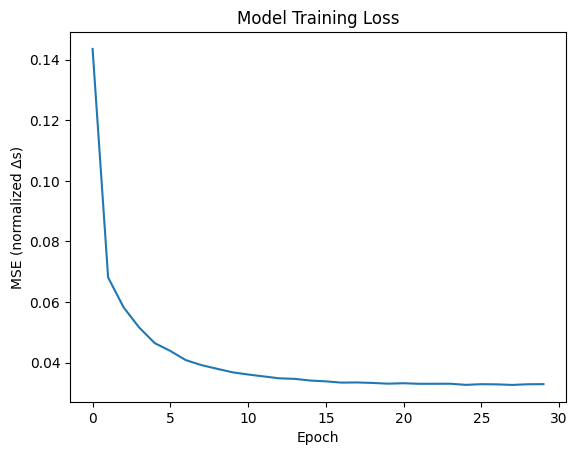

In [10]:
def train_model(model, replay, epochs=30, batch_size=256):
    model.train()
    losses = []
    best = float("inf")
    best_state = None

    for ep in range(epochs):
        steps = max(1, replay.size // batch_size)
        ep_loss = 0.0

        for _ in range(steps):
            # Sample batch
            s, a, ds = replay.sample(batch_size)

            # Build normalized inputs & targets
            x   = np.concatenate([s, a], axis=-1)          # [s, a]
            x_n = inp_norm.normalize(x)                    # normalize inputs
            y_n = targ_norm.normalize(ds)                  # normalize Δs targets

            x_t = to_t(x_n).to(device)
            y_t = to_t(y_n).to(device)

            # Forward + MSE loss
            pred = model(x_t)                               # predicts normalized Δs
            loss = ((pred - y_t) ** 2).mean()

            # Backprop
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            ep_loss += loss.item()

        ep_loss /= steps
        losses.append(ep_loss)

        # Track best epoch (lowest training loss)
        if ep_loss < best:
            best = ep_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # LR scheduler step (Exponential decay) + show current LR
        scheduler.step()
        lr = opt.param_groups[0]['lr']
        print(f"Epoch {ep+1:02d}/{epochs} | loss={ep_loss:.6f} | lr={lr:.6g}")

    # Load best weights (by training loss)
    if best_state is not None:
        model.load_state_dict(best_state)

    return losses

# Train for 30 epochs with batch size 256 and plot
losses = train_model(model, replay, epochs=30, batch_size=256)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-step Δs MSE (full state):  0.615935
One-step Δs MSE (qvel[0]):     0.025623


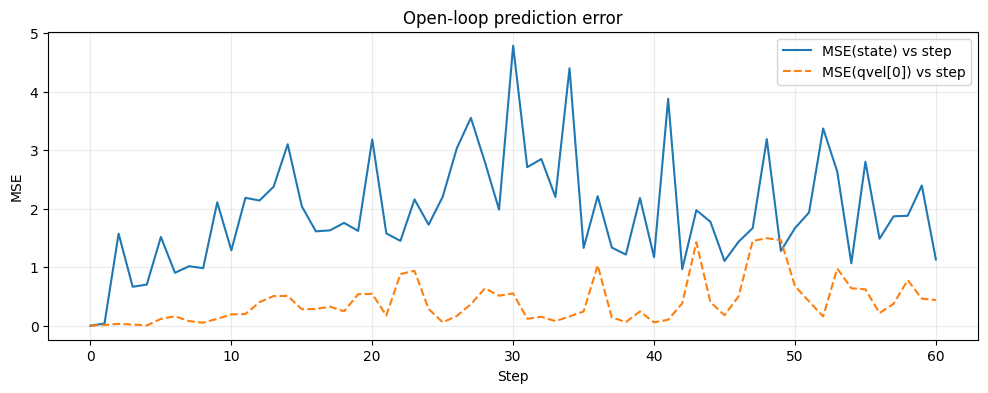

In [14]:
# ---------- Predict next state from (s, a) ----------
def predict_next(model, s, a):
    """
    Inputs
      s:  (obs_dim,) np.float32
      a:  (act_dim,) np.float32
    Returns
      s_next_model: (obs_dim,) np.float32 predicted next state
    """
    x = np.concatenate([s, a], axis=-1)     # [s, a]
    x_n = inp_norm.normalize(x)             # normalize inputs
    x_t = to_t(x_n).to(device)

    with th.no_grad():                      # no gradient for eval
        y_n = model(x_t).cpu().numpy()      # normalized Δs

    ds = targ_norm.denormalize(y_n)         # back to real-scale Δs
    return s + ds                           # s' = s + Δs


# ---------- One-step holdout MSE ----------
def one_step_holdout_mse(env, model, n_samples=5000, seed=123):
    """
    Collect brand-new random transitions and measure one-step Δs MSE
    between env and model, including the forward-velocity component.
    """
    set_seed(seed)
    s, _ = env.reset(seed=seed)

    mse_full = 0.0
    mse_vx   = 0.0
    n = 0

    for _ in range(n_samples):
        a = env.action_space.sample()
        sp_env, r, term, trunc, _ = env.step(a)

        # Env target Δs
        ds_env = sp_env - s

        # Model predicted next state and Δs
        sp_model = predict_next(model, s, a)
        ds_model = sp_model - s

        # Accumulate errors
        mse_full += np.mean((ds_model - ds_env) ** 2)
        mse_vx   += float((ds_model[qvel_start] - ds_env[qvel_start]) ** 2)

        s = sp_env
        if term or trunc:
            s, _ = env.reset()
        n += 1

    return mse_full / max(n, 1), mse_vx / max(n, 1)


# ---------- Open-loop (multi-step) rollout error ----------
def open_loop_rollout_error(env, model, horizon=60, episodes=5, seed=2025):
    """
    From the same start state, drive both ENV and MODEL with the same random actions.
    Compare states at every step to see how error grows with horizon.
    Returns per-step MSE (full state) and forward-velocity MSE.
    """
    set_seed(seed)
    per_step = np.zeros(horizon + 1, dtype=np.float64)
    per_step_vx = np.zeros(horizon + 1, dtype=np.float64)

    for ep in range(episodes):
        s_real, _ = env.reset(seed=seed + ep)
        s_model = s_real.copy()

        for t in range(horizon + 1):
            # error at time t
            per_step[t]   += np.mean((s_model - s_real) ** 2)
            per_step_vx[t]+= float((s_model[qvel_start] - s_real[qvel_start]) ** 2)

            if t == horizon:
                break

            a = env.action_space.sample()

            # env next
            sp_real, r, term, trunc, _ = env.step(a)

            # model next
            s_model = predict_next(model, s_model, a)
            s_real  = sp_real

            if term or trunc:
                break

    per_step   /= max(episodes, 1)
    per_step_vx/= max(episodes, 1)
    return per_step, per_step_vx


# ---------- Run the validations ----------
mse_1_full, mse_1_vx = one_step_holdout_mse(env, model, n_samples=5000, seed=123)
print(f"One-step Δs MSE (full state):  {mse_1_full:.6f}")
print(f"One-step Δs MSE (qvel[0]):     {mse_1_vx:.6f}")

horizon = 60
episodes = 5
per_step_mse, per_step_mse_vx = open_loop_rollout_error(env, model, horizon=horizon, episodes=episodes, seed=2025)

# ---------- Plot error growth ----------
t = np.arange(horizon + 1)
plt.figure(figsize=(12, 4))
plt.plot(t, per_step_mse, label="MSE(state) vs step")
plt.plot(t, per_step_mse_vx, "--", label="MSE(qvel[0]) vs step")
plt.xlabel("Step")
plt.ylabel("MSE")
plt.title(f"Open-loop prediction error")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



In [1]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    # Eval mode: turn off dropout/BN behavior; we’ll also avoid grad tracking inside the loop.
    model.eval()
    set_seed(seed)

    # Reset env and capture initial state
    s_real, _ = env.reset(seed=seed)
    real_traj = [s_real.copy()]
    model_traj = [s_real.copy()]

    # Pre-sample k actions so ENV and MODEL see the exact same sequence
    actions = [env.action_space.sample() for _ in range(k)]

    for a in actions:
        # --- Real env step ---
        sp_real, r, term, trunc, _ = env.step(a)
        real_traj.append(sp_real.copy())

        # --- Model step (predict Δs from [s_model, a]) ---
        s_model = model_traj[-1]
        x   = np.concatenate([s_model, a], axis=-1)        # [s, a]
        x_n = inp_norm.normalize(x)                        # normalize inputs
        x_t = to_t(x_n).to(device)

        with th.no_grad():
            y_n = model(x_t).cpu().numpy()                 # normalized Δs

        ds = targ_norm.denormalize(y_n)                    # back to real-scale Δs
        sp_model = s_model + ds
        model_traj.append(sp_model.copy())

        if term or trunc:
            break

    # To arrays for plotting
    real_traj  = np.asarray(real_traj)    # shape: T+1, obs_dim
    model_traj = np.asarray(model_traj)   # shape: T+1, obs_dim
    T = min(len(real_traj), len(model_traj))
    t = np.arange(T)

    # Plot requested state dimensions
    plt.figure(figsize=(14, 5))
    for d in dims:
        plt.plot(t, real_traj[:T, d], label=f"real[{d}]")
        plt.plot(t, model_traj[:T, d], linestyle="--", label=f"model[{d}]")
    plt.xlabel("t (steps)")
    plt.ylabel("state value")
    plt.title(f"Open-loop rollout (length {T-1}) — real vs model")
    plt.legend(ncol=4, fontsize=9)
    plt.grid(True, alpha=0.25)
    plt.show()


# Uncomment to visualize
dims = list(range(1, 17))
# visualize_rollout(env, model, k=50, dims=dims)  # or e.g., dims=(qvel_start, qvel_start+1, qvel_start+2)



## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



1.How good is your model?

Overall, the model does a pretty good job at predicting small, one-step changes in the state.
When I compare the predicted next state to the real environment, the error is low and the short-term trajectory looks similar.
But once I let the model run for many steps in a row (open-loop rollout), the error keeps adding up and the prediction drifts away from the real motion.
So it captures the local dynamics well but is not perfect for long-term predictions.

2.Is this training enough for planning, or do we need continual training?

This initial training on random rollouts isn't enough for good planning.
The data we used only covers states that a random agent visits, not the ones a controller or planner will actually see.
To make the model reliable for decision-making, we would need to keep training it as we collect new data from the policy in use basically a loop of collect → train → plan → collect again.
That continual retraining helps the model stay accurate in the parts of the environment that really matter for control.


3.How is this system different from the mountain car problem? Why can't we learn this in one episode?

HalfCheetah is much more complicated.
It has 17 state variables and 6 actions, while Mountain Car only has two state values and one action.
The cheetah's movement involves many joints, contacts with the ground, and nonlinear physics, so a single episode can't possibly cover all the different positions and velocities it can reach.
That's why we need lots of episodes and random exploration to learn its dynamics properly — one episode just doesn't give enough data.

4.Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class?

Because the data distribution keeps changing as we collect more rollouts or update our policy.
If we used a fixed mean and standard deviation from the first batch, later data could be scaled incorrectly and hurt training.
A RunningNormalizer keeps updating its running mean and variance online, so the inputs and targets always stay roughly zero-mean and unit-variance.
This makes the learning process more stable and adaptive over time.
